### Desafio:
Plotar um gráfico de mapa com as informações de risco de câncer dos condados dos EUA baseado em informações dos centros dos condados e uma base de dados de risco de câncer.

In [43]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [38]:
#conhecendo os dados
df_cancer_risk = pd.read_csv('cancer_risk_trimmed_solution.csv', header=None)
df_cancer_risk.head()

,0,1,2,3,4
0,NY,New York,36061,1537195,0.000150
1,CA,Los Angeles,06037,9519338,0.000110
2,NY,Bronx,36005,1332650,0.000110
3,CA,Orange,06059,2846289,0.000098
4,NY,Kings,36047,2465326,0.000098


In [21]:
df_usa_centers = pd.read_csv('USA_Counties_with_FIPS_and_centers.csv', header=None)
df_usa_centers.head()

,0,1,2
0,02185,73.851847,264.844023
1,02188,62.019282,278.311918
2,02130,141.912104,319.270889
3,02201,139.945631,320.219078
4,02280,135.736000,316.594968


#### Problema 1: Unificar as bases de dados
As informações de centros dos condados e do risco de câncer estão em arquivos CSV distintos. Há uma coluna de código FIPS que pode ser utilizada para unificá-las.

In [23]:
"""
Objetivo:
Ler dois arquivos CSV e uní-los baseado nas informações do código FIPS
Analisar ambas as fontes de dados em busca de códigos FIPS despadronizados
"""
import csv

def read_csv_file(file_name):
    """
    Input:
      file_name - String do nome do arquivo CSV
      
    Output:
      csv_table - Lista aninhada contendo os campos do arquivo CSV
      
    Ação:
      Dado um arquivo CSV, lê as informações para uma lista aninhada
    """  
    with open(file_name, newline='') as csv_file:
        csv_table = []
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            csv_table.append(row)
    return csv_table

#Exemplo de aplicação:
read_csv_file('cancer_risk_trimmed_solution.csv')[10:15]

[['CA', 'San Francisco', '06075', '776733', '8.4E-05'],
 ['CO', 'Denver', '08031', '554636', '7.9E-05'],
 ['CA', 'Statewide', '06000', '33871648', '7.7E-05'],
 ['CA', 'San Bernardino', '06071', '1709434', '7.7E-05'],
 ['DC', 'Statewide', '11000', '572059', '7.7E-05']]

In [8]:
def write_csv_file(csv_table, file_name):
    """
    Input:
      csv_table - Lista aninhada
      file_name - Nome do arquivo CSV
      
    Output:
      Retorna None
      
    Ação:
      Escreve os campos da csv_table em um arquivo CSV 
      separado por vírgulas com o nome file_name.
    """
    with open(file_name, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        for row in csv_table:
            csv_writer.writerow(row)

#Exemplo de aplicação:
write_csv_file(read_csv_file('cancer_risk_trimmed_solution.csv'), 'cancer_risk_trimmed_solution2.csv')

In [24]:
def make_dict(table, key_col):
    """
    Inputs:
      table       - Tabela 2D (lista de listas)
      key_col     - Coluna de índice
      
    Output:
      answer_dict - Dicionário onde as chaves são entradas
      de uma coluna específica, e seus valores são listas
      contendo as demais entradas de cada linha.
    """
    answer_dict = {}
    for row in table:
        key = row[key_col]
        copy_row = list(row)
        copy_row.pop(key_col)
        answer_dict[key] = copy_row
    return answer_dict

#Exemplo de aplicação:
tabela1 = [[1, 2],
           [3, 4],
           [5, 6]]
tabela2 = [[1, 2, 3],
           [2, 4, 6],
           [3, 6, 9]]
print('tabela1, índice 0:\n',make_dict(tabela1, 0), '\n')
print('tabela1, índice 1:\n',make_dict(tabela1, 1), '\n')
print('tabela2, índice 1:\n',make_dict(tabela2, 1), '\n')
print('tabela2, índice 2:\n',make_dict(tabela2, 2), '\n')

tabela1, índice 0:
 {1: [2], 3: [4], 5: [6]} 

tabela1, índice 1:
 {2: [1], 4: [3], 6: [5]} 

tabela2, índice 1:
 {2: [1, 3], 4: [2, 6], 6: [3, 9]} 

tabela2, índice 2:
 {3: [1, 2], 6: [2, 4], 9: [3, 6]} 



In [25]:
def merge_csv_files(cancer_csv_file, center_csv_file, joined_csv_file, cancer_fips_col, center_fips_col):
    """
    Inputs:
      cancer_csv_file - Nome do arquivo CSV das informações de risco de câncer
      center_csv_file - Nome do arquivo CSV com as informações do centro de cada condado dos EUA
      joined_csv_file - Nome do arquivo CSV a ser criado.
      cancer_fips_col - Número da coluna do arquivo cancer_csv_file que possui os dados de código FIPS
      center_fips_col - Número da coluna do arquivo center_csv_file que possui os dados de código FIPS
      
    Output:
      Retorna None
      
    Ação:
      Lê dois arquivos CSV como tabelas.
      Une as informações em uma única tabela através
      do código FIPS compartilhado.
      Escreve um novo arquivo com as informações unificadas.
      Analisa códigos FIPS problemáticos.
    """
    # lendo os dois arquivos CSV
    risk_table = read_csv_file(cancer_csv_file)
    print('Tabela de risco lida com tamanho', len(risk_table))
    
    center_table = read_csv_file(center_csv_file)
    print('Tabela de centros lida com tamanho', len(center_table))

    center_dict = make_dict(center_table, center_fips_col)
    
    # desenvolve a tabela unida e imprime alertas sobre códigos FIPS da tabela de risco de
    # câncer que não existem no mapa dos EUA.
    joined_table =[]
    for row in risk_table:
        FIPS_code = row[cancer_fips_col]
        if FIPS_code in center_dict:
            joined_table.append(row + center_dict[FIPS_code])
        else:
            print('linha', row, 'da tabela de risco de câncer não está presente no mapa dos EUA')

    # escreve a tabela unida
    print('Nova tabela escrita com tamanho', len(joined_table))
    write_csv_file(joined_table, joined_csv_file)
    
    # imprime alertas sobre códigos FIPS no mapa dos EUA que estão faltantes nos
    # dados de risco de câncer
    print()
    risk_codes =[risk_table[idx][cancer_fips_col] for idx in range(len(risk_table))]
    for center_code in center_dict:
        if center_code not in risk_codes:
            print('Código', center_code, 'na tabela de centros não está presente na tabela de risco de câncer')

#Exemplo de aplicação:
merge_csv_files("cancer_risk_trimmed_solution.csv", 
                "USA_Counties_with_FIPS_and_centers.csv", 
                "cancer_risk_joined.csv", 
                cancer_fips_col=2, 
                center_fips_col=0)

Tabela de risco lida com tamanho 3276
Tabela de centros lida com tamanho 3143
linha ['CA', 'Statewide', '06000', '33871648', '7.7E-05'] da tabela de risco de câncer não está presente no mapa dos EUA
linha ['DC', 'Statewide', '11000', '572059', '7.7E-05'] da tabela de risco de câncer não está presente no mapa dos EUA
linha ['NY', 'Statewide', '36000', '18976457', '7.2E-05'] da tabela de risco de câncer não está presente no mapa dos EUA
linha ['MD', 'Statewide', '24000', '5296486', '5.7E-05'] da tabela de risco de câncer não está presente no mapa dos EUA
linha ['NJ', 'Statewide', '34000', '8414350', '5.6E-05'] da tabela de risco de câncer não está presente no mapa dos EUA
linha ['AZ', 'Statewide', '04000', '5130632', '5.5E-05'] da tabela de risco de câncer não está presente no mapa dos EUA
linha ['OR', 'Statewide', '41000', '3421399', '5.5E-05'] da tabela de risco de câncer não está presente no mapa dos EUA
linha ['CT', 'Statewide', '09000', '3405565', '5.3E-05'] da tabela de risco de câ

Código State_Lines na tabela de centros não está presente na tabela de risco de câncer
Código separator na tabela de centros não está presente na tabela de risco de câncer


In [29]:
#examinando a tabela criada
df_joined = pd.read_csv('cancer_risk_joined.csv', header=None)
df_joined.head()

,0,1,2,3,4,5,6
0,NY,New York,36061,1537195,0.000150,505.645305,114.251808
1,CA,Los Angeles,6037,9519338,0.000110,58.480269,199.346442
2,NY,Bronx,36005,1332650,0.000110,506.335101,113.080892
3,CA,Orange,6059,2846289,0.000098,63.268732,204.594977
4,NY,Kings,36047,2465326,0.000098,505.935547,115.998088


#### Problema 2: Plotar as informações em um gráfico de mapa
Utilizar as informações tabeladas e unificadas para criar uma representação visual.

In [26]:
"""
Objetivo: 
Carregar um mapa PNG dos EUA e plotar dados de risco
de câncer nos centros dos condados.
"""



# Tamanho da imagem SVG do mapa dos EUA
USA_SVG_SIZE = [555, 352]

# Código para computar a área de traçagem para o scatter()
SCATTER_SCALE = math.pi / (200.0 ** 2)

def compute_county_circle(county_population):
    """
    Input:
      county_population                 - População do condado (int)
    
    Output:
      SCATTER_SCALE * county_population - Área do círculo proporcional à
                                          população para uso como opção
                                          para o scatter() no matplotlib
    """
    return  SCATTER_SCALE * county_population

#Exemplo de aplicação
compute_county_circle(5000000)

392.6990816987241

In [27]:
# risco máximo de câncer na base de dados
MAX_LOG_RISK = math.log(1.50E-04, 10)
# risco mínimo de câncer na base de dados
MIN_LOG_RISK = math.log(8.60E-06, 10)

def create_riskmap(colormap):
    """
    Input:
      colormap                                               - Mapa de cores do matplotlib
      
    Output:
      lambda risk : color_mapper.to_rgba(math.log(risk, 10)) - Função que recebe o risco de
                                                               câncer e retorna o range de
                                                               cores RGB para ser utilizado
                                                               com o scatter() do matplotlib.
    """
    risk_norm = mpl.colors.Normalize(vmin = MIN_LOG_RISK, vmax = MAX_LOG_RISK)
    color_mapper = mpl.cm.ScalarMappable(norm = risk_norm, cmap = colormap)
    return lambda risk : color_mapper.to_rgba(math.log(risk, 10))

#Exemplo de aplicação:
create_riskmap(mpl.cm.jet)

<function __main__.create_riskmap.<locals>.<lambda>(risk)>

Dimensões: 1000 634 4


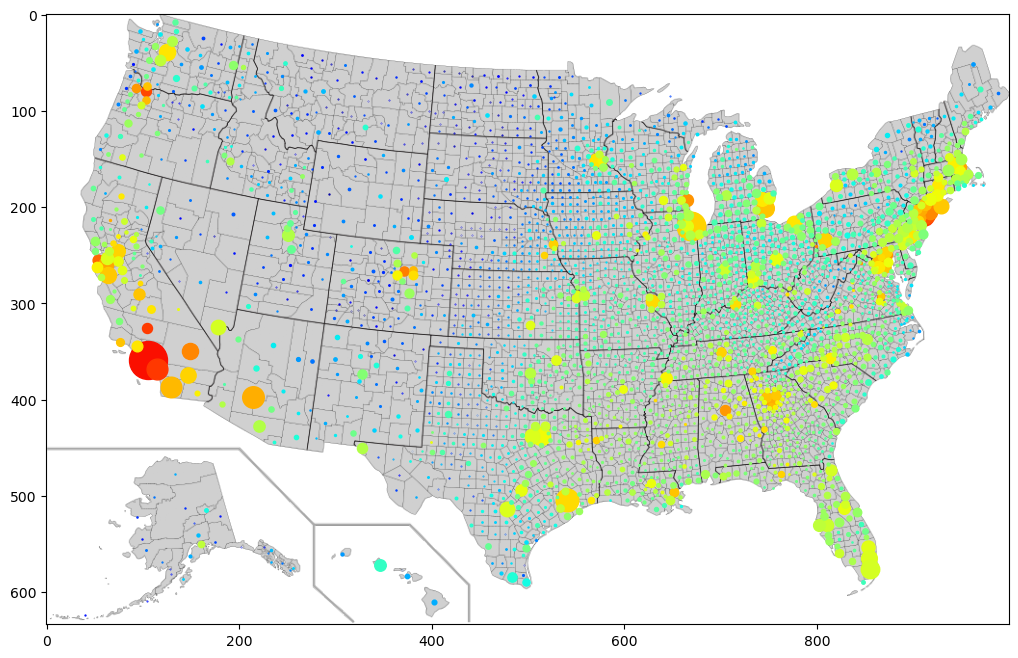

In [47]:
# coluna da tabela unificada que contém o risco de câncer
RISK_COLUMN = 4

def draw_cancer_risk_map(joined_csv_name, map_name, num_counties = None):
    """
    Inputs:
      joined_csv_file - Nome do arquivo CSV unificado
      map_name        - Nome do mapa PNG dos EUA
      num_counties    - Especifica o número de condados a serem desenhados
      
    Output:
      Retorna None
      
    Ação:
      Dados os nomes do arquivo CSV joined_csv_file e o mapa dos EUA map_name,
      desenha os dados de risco de câncer para cada condado dos EUA. O argumento
      opcional especifica o número de condados a serem desenhados.
    """
     
    # carregando a imagem PNG dos EUA.
    with open(map_name, 'rb') as map_file:
        map_img = plt.imread(map_file)
        
    # adquirindo as dimensões da imagem carregada
    ypixels, xpixels, bands = map_img.shape
    print('Dimensões:',xpixels, ypixels, bands)
    
    # opcional: código para redimensionar as informações em
    # uma figura de tamanho fixo
    DPI = 80.0                  # ajuste esta constante para redimensionar a figura
    xinch = xpixels / DPI
    yinch = ypixels / DPI
    plt.figure(figsize=(xinch,yinch))

    # plotando o mapa dos EUA
    implot = plt.imshow(map_img)
    
    # carregando os dados da tabela unificada
    joined_cancer_risk_table = read_csv_file(joined_csv_name)
    # organizando a coluna de risco de câncer em ordem decrescente
    joined_cancer_risk_table.sort(key = lambda row: float(row[RISK_COLUMN]), reverse = True)
    
    # acionando a função que mapeia o risco de câncer para uma paleta RGB
    risk_map = create_riskmap(mpl.cm.jet)
    
    # desenha os dados de risco de câncer para cada condado como círculos.
    # as cores indicam o risco e a área representa a população
    for row in joined_cancer_risk_table[: num_counties]:
        county_population = int(row[3])
        county_cancer_risk = float(row[4])
        county_xcenter = float(row[5])
        county_ycenter = float(row[6])
        plt.scatter(x = county_xcenter * xpixels / USA_SVG_SIZE[0],
                    y = county_ycenter * ypixels / USA_SVG_SIZE[1],
                    s = compute_county_circle(county_population),
                    color = np.array(risk_map(county_cancer_risk)))
        
    plt.show()

#Exemplos de aplicação:
#draw_cancer_risk_map("cancer_risk_joined.csv", "USA_Counties_555x352.png", 200)
draw_cancer_risk_map("cancer_risk_joined.csv", "USA_Counties_1000x634.png") 